In [1]:
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.patheffects as path_effects
%matplotlib inline
from fitsio import FITS,FITSHDR
from scipy.interpolate import RectBivariateSpline,interp2d
from tqdm import tqdm
from glob import glob
import scipy.io as sio
from scipy import signal

In [2]:
def lsfitter(x_orig,y_orig,x_fit,y_fit,bins,plot=False,fit_type='shift'):

    if (len(np.where(np.isfinite(y_orig))[0])==0) | (len(np.where(np.isfinite(x_orig))[0])==0):
        if fit_type == 'shift':
            return 0
        if fit_type == 'flux':
            return 1

    if fit_type=='shift':
        chi=np.zeros(len(bins))
        for i in xrange(len(bins)):
            chi[i]=(1./float(len(y_fit)))*np.nansum(((y_fit-np.interp(x_fit,x_orig+bins[i],y_orig))**2)/(y_fit))
        if plot==True:
            plt.figure()
            plt.plot(bins,chi)
            plt.axvline(bins[np.argmin(chi)])
        return bins[np.argmin(chi)]
    if fit_type=='flux':
        chi=np.zeros(len(bins))
        for i in xrange(len(bins)):
            chi[i]=(1./float(len(y_fit)))*np.nansum(((y_fit-y_orig*bins[i])**2)/y_fit)
        if plot==True:
            plt.figure()
            plt.plot(bins,chi)
            plt.axvline(bins[np.argmin(chi)])
    return bins[np.argmin(chi)]
def lsfitter_r(x_orig,y_orig,x_fit,y_fit,fit_type='shift',plot=False,n=100,max=1):
    loc=0.
    for loop in np.arange(3.):
        bins=np.logspace(np.log10(0.001/(10.**loop)),np.log10(max/(10.**loop)),n/2)
        bins=np.append(np.sort(-bins),bins)+loc
        if fit_type=='flux':
            bins+=1
        loc=lsfitter(x_orig,y_orig,x_fit,y_fit,bins,fit_type=fit_type,plot=plot)
    return loc

In [3]:
def qualify(time,data,times):
        x,y=time,np.nansum(np.nansum(data,axis=1),axis=1)
        s=set(np.arange(len(data)))
        for b in times:
            low,high=np.asarray(b.split(':'),dtype=float)
            bs=set(np.where((x>=low)&(x<=high))[0])
            s=s-bs
        bs=set(np.where(y==0)[0])
        s=s-bs
        return np.asarray(list(s))
def rebin3d(x,n,m):
    x2d=(np.meshgrid(x,np.zeros(n))[0]).T
    x3d=[]
    for i in xrange(m):
        x3d.append(x2d)
    x3d=(np.asarray(x3d).transpose(1,2,0))
    return x3d
def fluxplot(infile='../data/dip.fits',plot=True,plotname=None):
    data = fitsio.read(infile,ext=1,columns='FLUX')
    time = fitsio.read(infile,ext=1,columns='TIME')
    x,y=time,np.nansum(np.nansum(data,axis=1),axis=1)
    ok=np.where(y>np.nanmedian(y)*0.05)[0]
    x,y=x[ok],y[ok]
    if plot==True:
        fig,ax=plt.subplots()
        ax.plot(x,y)
        ax.set_xlabel('Time')
        ax.set_ylabel('Total Counts')


    
    g=np.where(np.abs(y-np.nanmedian(y))<2*np.nanstd(y))[0]
    l=np.polyfit(x[g],y[g],2)
    d=np.where(-(y-np.nanmedian(y))>4*np.nanstd(y[g]))[0]
    if len(d)==0:
        if plot==True:
            if (plotname is None)==False:
                plt.savefig(plotname,dpi=150,bbox_inches='tight')
                plt.close()
            else:
                plt.show()
        return []
    else:
        dt=(d[1:]-d[0:-1])

        p1,p2=[d[0]],[d[0]]
        for d1,dt1 in zip(d[1:],dt):
            if dt1==1:
                p2[-1]+=1
            else:
                p1.append(d1)
                p2.append(d1)

        times=[]
        for i,j in zip(p1,p2):
            ddt=(j-i)*2
            if plot==True:
                plt.scatter(x[i-ddt:j+ddt],y[i-ddt:j+ddt],color='C3')
            times.append('{}:{}'.format(np.round(x[i-ddt],2),np.round(x[j+ddt],2)))


        if plot==True:
            if (plotname is None)==False:
                plt.savefig(plotname,dpi=150,bbox_inches='tight')
                plt.close()
            else:
                plt.show()
        return times

In [4]:
import scipy.io as sio
from glob import glob


def animateim(vals,labels=None,outfile='out.mp4',title=None):
    def update_img(n):
        image_plot.set_data(vals[n])
        if (labels is None)==False:
            label_text.set_text(labels[n])
        return image_plot,label_text

    fig=plt.figure(figsize=(5,5))
    ax=plt.subplot(111)
    if (title is None)==False:
        ax.set_title(title)
    plt.xticks([])
    plt.yticks([])
    image_plot=ax.imshow(vals[0],origin='bottom')
    if (labels is None)==False:
        label_text=ax.text(np.shape(vals)[1]*0.9,np.shape(vals)[2]*0.9,'',color='white',ha='right',fontsize=20)
        label_text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
    ani = animation.FuncAnimation(fig,update_img,len(vals),interval=300)
    writer = animation.writers['ffmpeg'](fps=30)
    ani.save(outfile,writer=writer,dpi=100)
    
    
def animatemods(psfdir='../psf_models/psf_data_8_18_08/PSF_Mono/',imgdir='../images/'):
    cno=1
    for mno in xrange(25):
        fnames=glob('{}Module_{}/{}/*.mat'.format(psfdir,mno,mno+cno*0.1))
        if len(fnames)==0:
            continue
        h=sio.loadmat(fnames[0])
        psf=np.zeros((len(fnames),np.shape(h['psf'])[0],np.shape(h['psf'])[1]))
        lam=[]
        for i,f in enumerate(fnames):
            h=sio.loadmat(f)
            psf[i,:,:]=h['psf']
            lam.append(f.split('_')[-1][0:-4])
        animateim(np.log10(psf),labels=lam,outfile='{}psf_module{}.mp4'.format(imgdir,mno),title='Module {} Corner {}'.format(mno,cno))

In [5]:
def calc_psf(infile='../data/dip.fits',plotname='../images/3DPSF.png',times=None,plot=False,bad=['763:765']):
    data = fitsio.read(infile,ext=1,columns='FLUX')
    time = fitsio.read(infile,ext=1,columns='TIME')
    
    if times is None:
        times=fluxplot(infile,plot=True,plotname='../images/testplot.png')
        for b in bad:
            times=np.append(times,b)


    #Fit the x and y pixel shifts
    t0=np.nansum(np.nansum(data[0:10,:,:],axis=0),axis=0)
    t1=np.nansum(np.nansum(data[0:10,:,:],axis=0),axis=1)
    xshift,yshift=[],[]
    for d in tqdm(data):
        xshift.append(lsfitter_r(np.arange(len(t0)),t0,np.arange(len(t0)),np.nansum(d,axis=0),fit_type='shift'))
        yshift.append(lsfitter_r(np.arange(len(t1)),t1,np.arange(len(t1)),np.nansum(d,axis=1),fit_type='shift'))
    xshift=np.asarray(xshift)
    yshift=np.asarray(yshift)

    ok=qualify(time,data,times)
    x3d=rebin3d(xshift,n=np.shape(data)[1],m=np.shape(data)[2])
    y3d=rebin3d(yshift,n=np.shape(data)[1],m=np.shape(data)[2])

    xp,yp=np.meshgrid(np.arange(np.shape(data)[1]),np.arange(np.shape(data)[2]))
    xpix,ypix=[],[]
    for i in xrange(len(data)):
        xpix.append(xp)
        ypix.append(yp)
    xpix,ypix=np.asarray(xpix).transpose(0,2,1),np.asarray(ypix).transpose(0,2,1)
    
    x3d+=xpix
    y3d+=ypix

    if plot==True:
        fig=plt.figure(figsize=(10,10))
        ax=fig.add_subplot(111,projection='3d')
        x=x3d[ok,:,:].ravel()
        y=y3d[ok,:,:].ravel(),
        z=data[ok,:,:].ravel()
        ax.scatter(x,y,zs=z,s=1,c=z)
        plt.savefig(plotname,dpi=fig.dpi,bbox_inches='tight')
        plt.close()
    return x3d,y3d,data,ok,time,xshift,yshift

In [6]:
x,y,d,ok,t,xs,ys=calc_psf('../data/test1/red_2.fits',plotname='../images/red_2.png',plot=False)

100%|██████████| 3279/3279 [00:59<00:00, 55.30it/s]
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater_equal
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less_equal


In [7]:
from astropy.io import fits
h=fits.open('../data/test1/red_2.fits')
mno=h[0].header['MODULE']
column,row,output=h[1].header['1CRV5P'],h[1].header['2CRV5P'],h[0].header['OUTPUT']
print column,row,output

729 303 2


In [8]:
psfdir='../psf_models/psf_data_8_18_08/PSF_Mono/'
fnames=glob('{}Module_{}/{}/*.mat'.format(psfdir,mno,mno+output*0.1))
h=sio.loadmat(fnames[0])
psf=np.zeros((len(fnames),np.shape(h['psf'])[0],np.shape(h['psf'])[1]))
res=h['grid_res'][0][0]
lam=[]
for i,f in enumerate(fnames):
    h=sio.loadmat(f)
    psf[i,:,:]=h['psf']
    lam.append(f.split('_')[-1][0:-4])

In [9]:
PRFx = np.arange(0., np.shape(psf[0])[0] + 0.)-np.shape(psf[0])[0]/2
PRFy = np.arange(0., np.shape(psf[0])[1] + 0.)-np.shape(psf[0])[0]/2
PRFx*=0.02
PRFy*=0.02
PRFX,PRFY=np.meshgrid(PRFx,PRFy)



/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


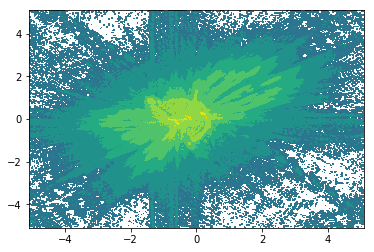

In [10]:
plt.contourf(PRFX,PRFY,np.log10(psf[0]))

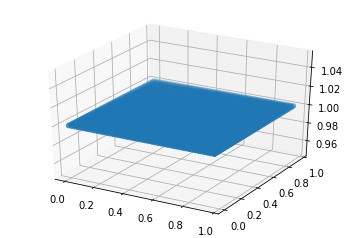

In [11]:
cx=PRFX[0][np.where(PRFX[0]>=0)[0][0]:np.where(PRFX[0]<1)[0][-1]]
cy=PRFY[:,0][np.where(PRFY[:,0]>=0)[0][0]:np.where(PRFY[:,0]<1)[0][-1]]
cx,cy=np.meshgrid(cx,cy)
prf=np.copy(cx)*0.+1.
fig=plt.figure()
ax=fig.add_subplot(111,projection='3d')
ax.scatter(cx,cy,prf)

In [ ]:
l=11
psf_c=signal.convolve2d(psf[l,:,:],prf,mode='same')
f=interp2d(PRFx,PRFy,psf_c)

In [ ]:
psf_i=f(x[ok,:,:].ravel(),y[ok,:,:].ravel())

In [ ]:
np.shape(psf_i)

array([ 4242384.38847611])

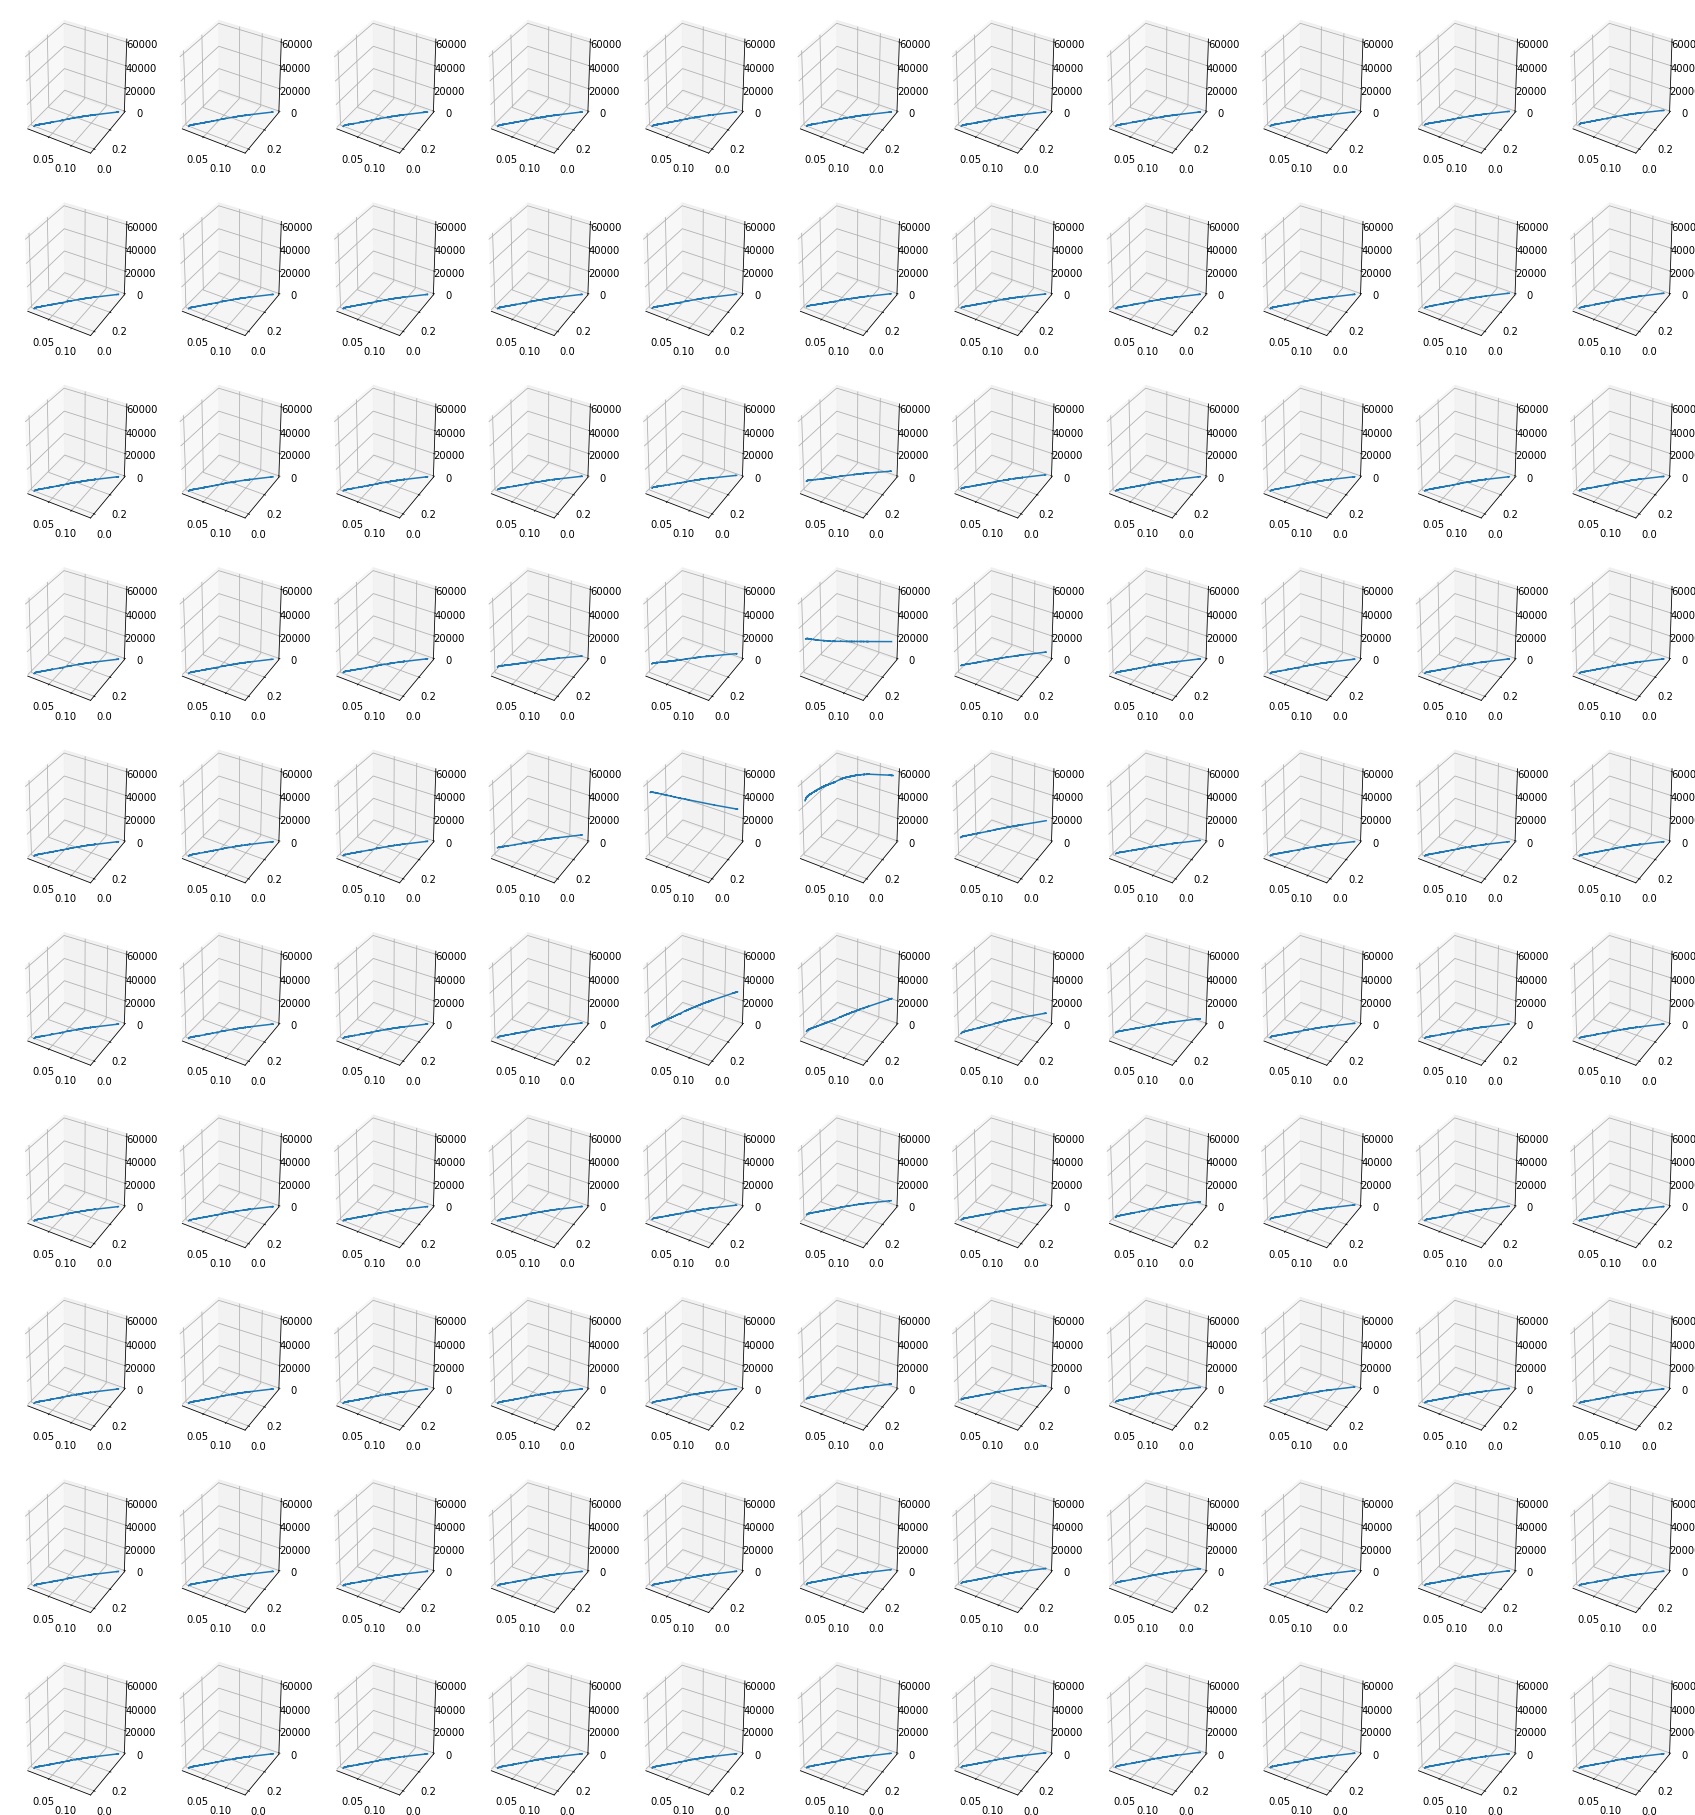

In [309]:
def plot3d(data,xshift,yshift,ok=None):
    if ok is None==False:
        ok=np.where((xshift>-1)&(yshift>-1))[0]
    n,m=np.shape(data)[1],np.shape(data)[2]
    fig= plt.figure(figsize=(np.max([n*3,10]),np.max([m*3,10])))
    c=1
    for i in xrange(n):
        for j in xrange(m):
            ax=fig.add_subplot(n,m,c,projection='3d')
            ax.plot(xshift,yshift,data[ok,i,j])
            c+=1
            ax.set_zlim(np.min(data[ok,:,:]),np.max(data[ok,:,:]))
            
plot3d(data,xshift,yshift,ok)